In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, xcipy, ensure_np_array
import apra_pop_models.fresnel_2dm as fresnel
import apra_pop_models.fraunhofer_2dm as fraunhofer
import apra_pop_models.dm as dm
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
import apra_pop_models.efc_2dm_embedded as emb_efc

import sys
sys.path.insert(len(sys.path), '/home/apra/Projects/embedded_howfsc/python_host')
import efc_host_utils

/home/apra/miniconda3/envs/gpu311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/apra/Projects/apra-howfsc-models/apra_pop_models


/home/apra/Projects/apra-howfsc-models/apra_pop_models


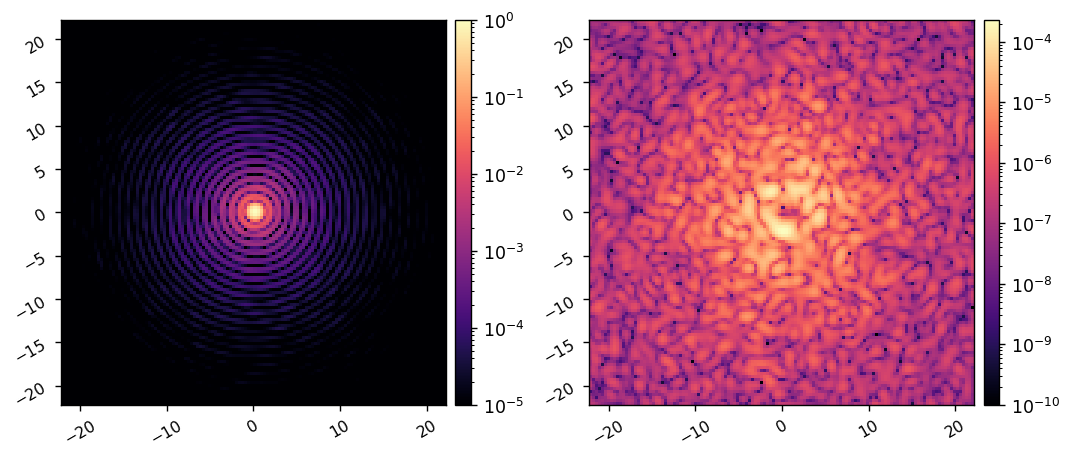

In [2]:
reload(fresnel)
reload(props)
reload(dm)

I = fresnel.CORO(
    Nact=34,
    npsf=128,
)
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref

I.use_vortex = True
ref_coro_im = I.snap()

imshow2(
    ref_psf, ref_coro_im,
    pxscl=I.psf_pixelscale_lamDc, 
    lognorm=True, vmin1=1e-5, vmin2=1e-10,
)

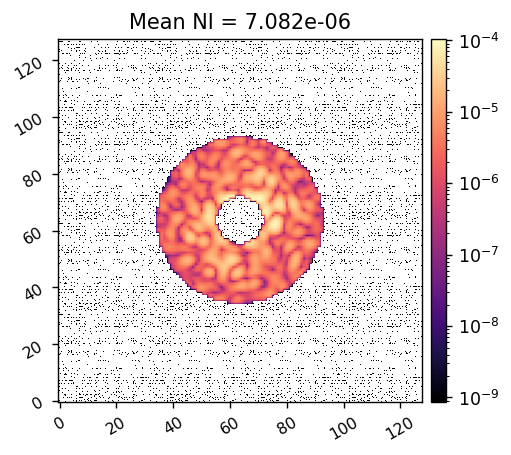

In [3]:
reload(efc_utils)
I.zero_dms()
iwa = 3
owa = 10
rot = 0

control_mask = efc_utils.create_annular_focal_plane_mask(
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    irad=iwa, 
    orad=owa, 
    edge=None, 
    rotation=rot,
)

mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

In [4]:
reload(utils)
jac = utils.load_fits('../jacobians/jac_34_2dm.fits')

In [6]:
reload(efc_host_utils)
EC = efc_host_utils.EmbeddedController()

In [7]:
EC.send_jacobian(ensure_np_array(jac))

In [8]:
EC.compute_gram()

# Run EFC without PWP

In [9]:
I.reset_dms()
efc_data = {
    'images':[ref_coro_im],
    'efields':[],
    'dm1_commands':[],
    'del_dm1_commands':[],
    'dm2_commands':[],
    'del_dm2_commands':[],
    'reg_conds':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [15]:
EC.do_decomposition(-2.5)

In [13]:
EC.do_decomposition(-5)

Beginning closed-loop EFC simulation.
	Running iteration 11/13.
	Mean NI of this iteration: 5.640e-10


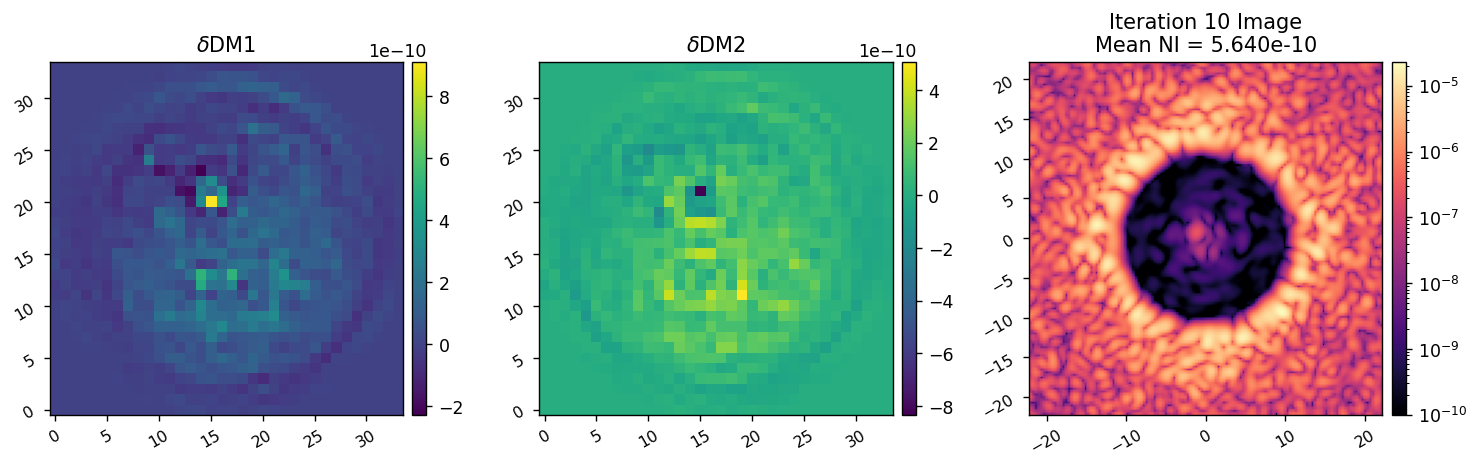

	Running iteration 12/13.
	Mean NI of this iteration: 5.532e-10


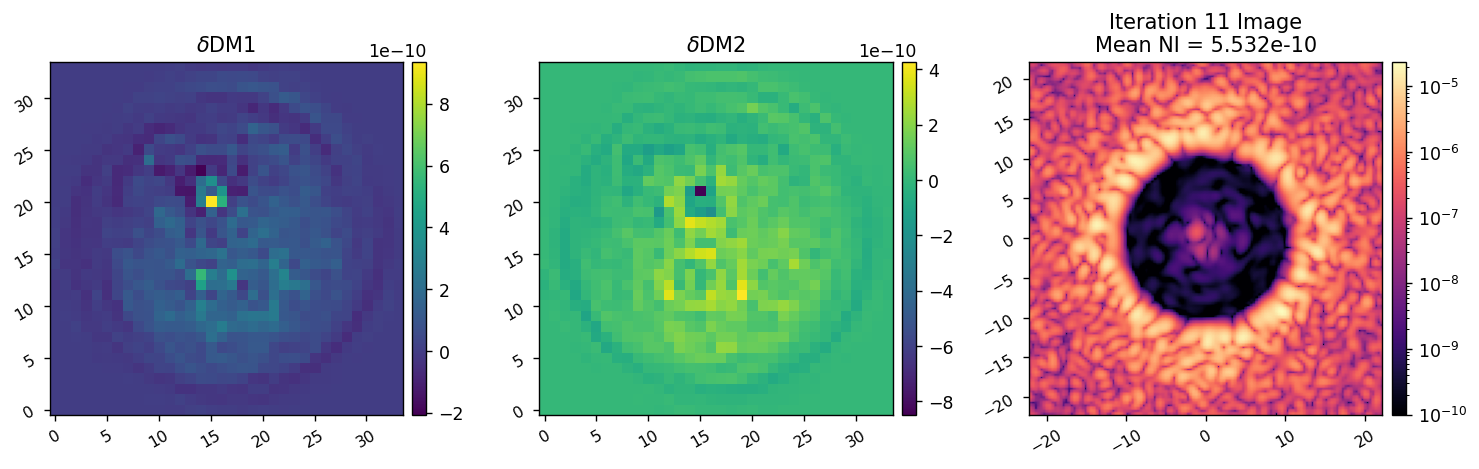

	Running iteration 13/13.
	Mean NI of this iteration: 5.718e-10


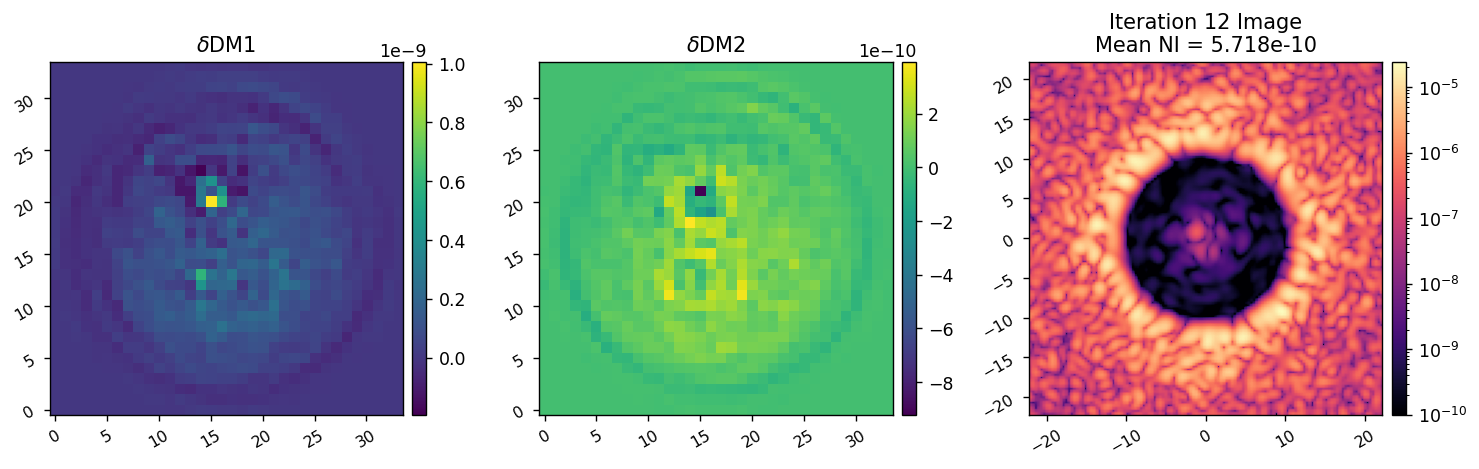

In [16]:
reload(emb_efc)

efc_data = emb_efc.run_with_decomp(
    I, 
    EC,
    efc_data, 
    # est_fun=pwp_fun, est_params=pwp_params,
    gain=1, 
    iterations=3, 
    plot_all=True,
)

In [17]:
utils.save_pickle('LS1046_efc_data.pkl', efc_data)

Saved data to:  LS1046_efc_data.pkl


In [ ]:
efc_data = utils.load_pickle()

In [26]:
EC.close()

Closing Host Utils


OSError: [Errno 9] Bad file descriptor